# Heatmap Parameters Analysis

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../../..')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import datetime

import numpy as np
import pandas as pd

from src.data import train_test_split, MRISequence
from src.model import create_model, compile_model, load_checkpoint
from src.model.evaluation import show_metrics

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['image.cmap'] = 'viridis'

%config InlineBackend.figure_format='retina'
plt.rcParams.update({'font.size': 15})

In [3]:
import tensorflow as tf

# RANDOM_SEED = 250398
# tf.random.set_seed(RANDOM_SEED)

print(tf.version.VERSION)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.3.2
Num GPUs Available:  1


## Setup

In [4]:
%%time

ROOT_DIR = '../../../../tmp'
DEFAULT_CHECKPOINT_DIRECTORY_LOCAL = os.path.join(ROOT_DIR, 'checkpoints')
DEFAULT_BCKP_CHECKPOINT_DIRECTORY_LOCAL = os.path.join(ROOT_DIR, 'bckp-checkpoints')

LOG_DIRECTORY = os.path.join(ROOT_DIR, 'logs')
CHECKPOINT_DIRECTORY = DEFAULT_CHECKPOINT_DIRECTORY_LOCAL

LOG_DIRECTORY_LOCAL = LOG_DIRECTORY
CHECKPOINT_DIRECTORY_LOCAL = CHECKPOINT_DIRECTORY

DATA_DIR_NAME = 'data-v3'
DATA_DIR = os.path.join(ROOT_DIR, DATA_DIR_NAME)

saliencies_and_segmentations_v2_path = os.path.join(ROOT_DIR, 'saliencies_and_segmentations_v2')

if not os.path.exists(CHECKPOINT_DIRECTORY):
    os.mkdir(CHECKPOINT_DIRECTORY)

if not os.path.exists(LOG_DIRECTORY):
    os.mkdir(LOG_DIRECTORY)

val = False

class_names = ['AD', 'CN']

# get paths to data
train_dir, test_dir, val_dir = train_test_split(
    saliencies_and_segmentations_v2_path,
    ROOT_DIR,
    split=(0.8, 0.15, 0.05),
    dirname=DATA_DIR_NAME)

# set the batch size for mri seq
batch_size = 12
input_shape = (104, 128, 104, 1) # (112, 112, 105, 1)
resize_img = True
crop_img = True

# if y is one-hot encoded or just scalar number
one_hot = True

# class weightss (see analysis notebook)
class_weights = {0: 0.8072289156626505, 1: 1.3137254901960784}

# description statistics of the dataset
desc = {'mean': -3.6344006e-09, 'std': 1.0000092, 'min': -1.4982183, 'max': 10.744175}

if 'desc' not in locals():
    print('initializing desc...')
    desc = get_description(MRISequence(
        train_dir,
        64,
        class_names=class_names,
        input_shape=input_shape),
        max_samples=None)
    print(desc)


normalization={ 'type':'normalization', 'desc': desc }
# normalization={'type':'standardization', 'desc':desc }

augmentations = None
augmentations_inplace = True
# enable augmentations in mri seq (otherwise it can be enabled in dataset)
# augmentations={ 'random_swap_hemispheres': 0.5 }

# initialize sequences
print('initializing train_seq...')
train_seq = MRISequence(
    train_dir,
    batch_size,
    class_names=class_names,
    augmentations=augmentations,
    augmentations_inplace=augmentations_inplace,
    input_shape=input_shape,
    resize_img=resize_img,
    crop_img=crop_img,
    one_hot=one_hot,
    class_weights=class_weights,
    normalization=normalization)

print('initializing test_seq...')
test_seq = MRISequence(
    test_dir,
    batch_size,
    class_names=class_names,
    input_shape=input_shape,
    resize_img=resize_img,
    crop_img=crop_img,
    one_hot=one_hot,
    normalization=normalization)

if val:
    print('initializing val_seq...')
    val_seq = MRISequence(
        val_dir,
        batch_size,
        class_names=class_names,
        input_shape=input_shape,
        resize_img=resize_img,
        crop_img=crop_img,
        one_hot=one_hot,
        class_weights=class_weights,
        normalization=normalization)
else:
    print('val_seq = test_seq')
    val_seq = test_seq

model_key = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
log_dir = os.path.join(LOG_DIRECTORY, model_key)
print(f'log_dir: {log_dir}')

not copying files since the destination directory already exists
initializing train_seq...
initializing test_seq...
val_seq = test_seq
log_dir: ../../../../tmp\logs\20210510-091043
Wall time: 0 ns


## Analysis

Each experiment consisted of 10 images, 5 TP and 5 TN.

In [5]:
from os import listdir
from os.path import isfile, join

fpath = os.path.join(ROOT_DIR, "risei-history/heatmap-parameters--b1-1-b2-0")

files = [f for f in listdir(fpath) if isfile(join(fpath, f))]
files[:5]

['hmap-parameters--deletion--m+1024-p1+0.25.cls',
 'hmap-parameters--deletion--m+1024-p1+0.3333333333333333.cls',
 'hmap-parameters--deletion--m+1024-p1+0.5.cls',
 'hmap-parameters--deletion--m+1024-p1+0.6666666666666666.cls',
 'hmap-parameters--deletion--m+1024-p1+0.75.cls']

In [6]:
import re


def parse(fname):
    p = re.compile("^hmap-parameters--(\w+)--m\+(\d+)-p1\+(\d+[.]?\d*)\.cls$")
    return p.match(fname).groups()

print(parse('hmap-parameters--deletion--m+1024-p1+0.6666666666666666.cls'))

('deletion', '1024', '0.6666666666666666')


In [7]:
from src.heatmaps.evaluation import HeatmapEvaluationHistory

data = {}


def append(key, value):
    if not key in data:
        data[key] = []
    data[key].append(value)

    
for fname in files:
    metric, masks_count, p1 = parse(fname)
    append('metric', metric)
    append('masks_count', int(masks_count))
    append('p1', float(p1))
    
    history = HeatmapEvaluationHistory.load(fpath, fname[:-4])
    desc = history._description()
    for key, value in desc.items():
        append(key, value)
    
    
df = pd.DataFrame(data=data)
df.head()

,metric,masks_count,p1,heatmaps,auc_mean,auc_p25,auc_median,auc_p75,auc_max,auc_min,auc_std
0,deletion,1024,0.250000,10,0.643593,0.563228,0.655659,0.724473,0.749755,0.538872,0.080467
1,deletion,1024,0.333333,10,0.640157,0.588006,0.627699,0.707924,0.738993,0.530580,0.068003
2,deletion,1024,0.500000,10,0.654849,0.626846,0.657283,0.689328,0.710017,0.584550,0.038588
3,deletion,1024,0.666667,10,0.623226,0.580452,0.601526,0.653028,0.756338,0.515370,0.071507
4,deletion,1024,0.750000,10,0.599749,0.545744,0.586926,0.666345,0.699307,0.496409,0.068916


In [8]:
def table(metric, value):
    df_m = df[df['metric'] == metric]
    df_m = df_m.sort_values('masks_count')
    return pd.pivot_table(df_m, values=value, index=["masks_count"], columns="p1", fill_value=0)

In [9]:
table('deletion', 'auc_median')

p1,0.250000,0.333333,0.500000,0.666667,0.750000
masks_count,,,,,
8,0.568857,0.560997,0.539627,0.574222,0.526298
16,0.569358,0.547365,0.518288,0.533546,0.510874
32,0.621808,0.579686,0.618804,0.591450,0.604745
64,0.600704,0.615240,0.612300,0.604009,0.602021
128,0.605690,0.570218,0.598747,0.608839,0.523231
256,0.627778,0.622465,0.605179,0.578617,0.588248
512,0.653583,0.622137,0.646226,0.605187,0.604104
1024,0.655659,0.627699,0.657283,0.601526,0.586926
2048,0.650490,0.621239,0.647952,0.618868,0.591306


In [10]:
table('insertion', 'auc_median')

p1,0.250000,0.333333,0.500000,0.666667,0.750000
masks_count,,,,,
8,0.579450,0.632806,0.572831,0.602406,0.627229
16,0.577185,0.623981,0.635889,0.646753,0.632246
32,0.596792,0.543668,0.557625,0.570270,0.588991
64,0.529210,0.526029,0.560768,0.554994,0.558734
128,0.554642,0.574473,0.605209,0.573860,0.556533
256,0.526284,0.504812,0.524492,0.544606,0.572755
512,0.508116,0.525889,0.514605,0.535332,0.567616
1024,0.484499,0.498557,0.536745,0.543785,0.554009
2048,0.492035,0.510781,0.536827,0.544496,0.552609


In [11]:
df_m = df.copy().sort_values("masks_count")
pd.pivot_table(df_m, values="auc_median", index=["masks_count"], columns=["p1", "metric"], fill_value=0)

p1           0.250000            0.333333            0.500000            \
metric       deletion insertion  deletion insertion  deletion insertion   
masks_count                                                               
8            0.568857  0.579450  0.560997  0.632806  0.539627  0.572831   
16           0.569358  0.577185  0.547365  0.623981  0.518288  0.635889   
32           0.621808  0.596792  0.579686  0.543668  0.618804  0.557625   
64           0.600704  0.529210  0.615240  0.526029  0.612300  0.560768   
128          0.605690  0.554642  0.570218  0.574473  0.598747  0.605209   
256          0.627778  0.526284  0.622465  0.504812  0.605179  0.524492   
512          0.653583  0.508116  0.622137  0.525889  0.646226  0.514605   
1024         0.655659  0.484499  0.627699  0.498557  0.657283  0.536745   
2048         0.650490  0.492035  0.621239  0.510781  0.647952  0.536827   

p1           0.666667            0.750000            
metric       deletion insertion  deletion insertion  
masks_count                                          
8            0.574222  0.602406  0.526298  0.627229  
16           0.533546  0.646753  0.510874  0.632246  
32           0.591450  0.570270  0.604745  0.588991  
64           0.604009  0.554994  0.602021  0.558734  
128          0.608839  0.573860  0.523231  0.556533  
256          0.578617  0.544606  0.588248  0.572755  
512          0.605187  0.535332  0.604104  0.567616  
1024         0.601526  0.543785  0.586926  0.554009  
2048         0.618868  0.544496  0.591306  0.552609

In [17]:
def map_p1(val):
    if val == 1/3:
        return 0.33
    if val == 2/3:
        return 0.66
    return val

def apply_fn(row):
#     print(row)
    if row['metric'] == 'deletion':
        row['auc_median'] = 1 - row['auc_median']
    row['p1'] = map_p1(row['p1'])
    return row

df_m = df.copy().sort_values("masks_count")
df_m = df_m.apply(apply_fn, axis=1)
p1_name = 'p'
masks_count_name = 'Počet masiek'
df_m = df_m.rename(columns={'p1': p1_name, 'masks_count': masks_count_name})

tt = pd.pivot_table(df_m, values="auc_median", index=[masks_count_name], columns=p1_name, fill_value=0) # value is mean of insertion and deletion auc_median
tt

p,0.25,0.33,0.50,0.66,0.75
Počet masiek,,,,,
8,0.505296,0.535904,0.516602,0.514092,0.550466
16,0.503914,0.538308,0.558800,0.556604,0.560686
32,0.487492,0.481991,0.469411,0.489410,0.492123
64,0.464253,0.455395,0.474234,0.475492,0.478357
128,0.474476,0.502128,0.503231,0.482511,0.516651
256,0.449253,0.441173,0.459657,0.482994,0.492253
512,0.427266,0.451876,0.434189,0.465073,0.481756
1024,0.414420,0.435429,0.439731,0.471129,0.483541
2048,0.420773,0.444771,0.444438,0.462814,0.480651


Text(0.5, 1.0, 'Kvalita tepelných máp metódy RISEI\n(b1 = 1, b2 = 0) podľa počtu masiek\na miery prekrytia v maskách')

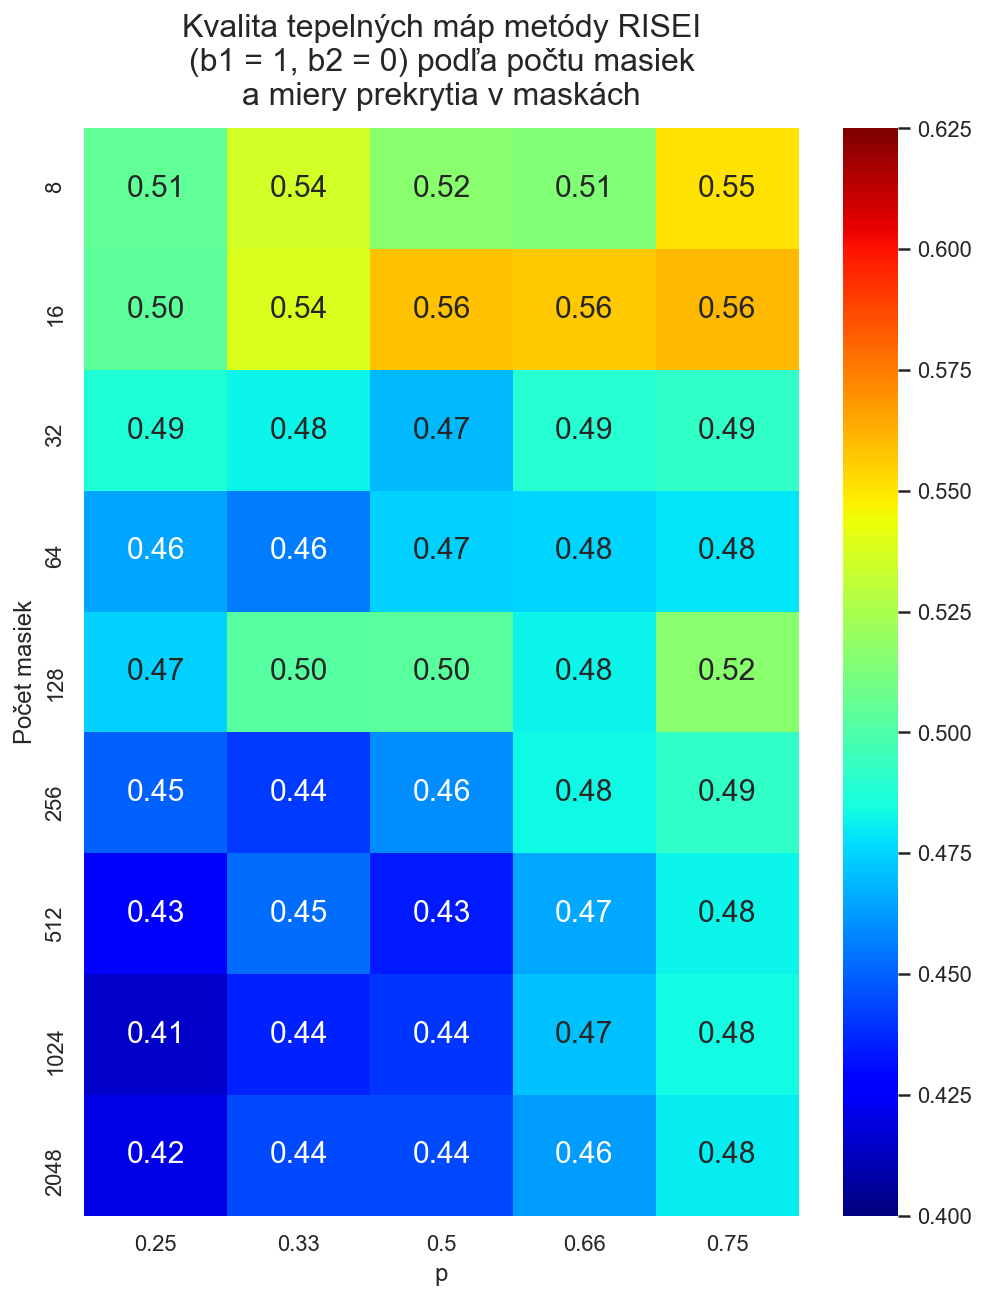

In [30]:
plt.rcParams['figure.figsize'] = (8, 10)
plt.rcParams['axes.titlesize'] = 16

ax = sns.heatmap(data=tt, annot=True, cmap='jet', vmin=0.40, vmax=0.625, fmt='.2f')
ax.set_title("Kvalita tepelných máp metódy RISEI\n(b1 = 1, b2 = 0) podľa počtu masiek\na miery prekrytia v maskách", pad=12)